# Monte Carlo Method for Value-function based learning



### Imports

In [ ]:
import gym
import random
from collections import defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter, MaxNLocator
%matplotlib inline
matplotlib.style.use('ggplot')

### Environment Setup

In [ ]:
# start a new blackjack env
env = gym.make('Blackjack-v1')

# number of games to play
episodes = 5000000

# use to discount rewards
gamma = 0.9

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Helper functions

In [ ]:
def get_epsilon(N_state_count, N_zero=50):
    """
    This is our function to calculate epsilon and is core to how we are going to pick our next action.

    We're initialising N_zero to 50, but this is a hyperparameter we can tune
    """
    return N_zero / (N_zero + N_state_count)

In [ ]:
def get_action(Q, state, state_count, action_size):
    """
    GLIE (Greedy in the Limit of Infinite Exploration) implementation for next action based on current state.
    """
    random_action = random.randint(0, action_size - 1)

    best_action = np.argmax(Q[state])

    epsilon = get_epsilon(state_count)

    return np.random.choice([best_action, random_action], p=[1. - epsilon, epsilon])

def get_thompson_action(Q, state, state_action_count, action_size):
    """
    Thompson Sampling implementation for next action based on current state.

    Parameters:
        Q (dict): The dictionary representing the value function.
        state (hashable): The current state of the environment.
        state_action_count (dict): The dictionary storing the count of state-action pairs visited.
        action_size (int): The total number of possible actions in the environment.

    Returns:
        int: The action to be taken by the agent.
    """
    # Calculate the exploration parameter for Thompson Sampling
    epsilon = get_epsilon(state_action_count)

    # Decide whether to explore or exploit based on the epsilon parameter
    if np.random.rand() < epsilon:
        # Explore: choose a random action
        return np.random.randint(action_size)
    else:
        # Exploit: choose the action with the maximum Q-value
        return np.argmax(Q[state])

In [ ]:
def evaluate_policy(Q, episodes=10000):
    """
    Evaluates how good our policy is.
    Plays 10000 games of blackjack and returns the win ratio.
    """
    wins = 0
    for _ in range(episodes):
        state = env.reset()

        done = False
        while not done:
            action = np.argmax(Q[state])

            state, reward, done, _ = env.step(action=action)

        if reward > 0:
            wins += 1

    return wins / episodes

In [ ]:
def monte_carlo(gamma=1., episodes=5000, evaluate=False):

    # this is our value function, we will use it to keep track of the "value" of being in a given state
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # keep track of state counts
    state_count = defaultdict(float)
    state_action_count = defaultdict(float)

    # for keeping track of our policy evaluations (we'll plot this later)
    evaluations = []

    for i in range(episodes):
        # evaluating a policy is slow going, so let's only do this every 1000 games
        if evaluate and i % 5000 == 0:
            evaluations.append(evaluate_policy(Q))

        # keep track of states we're in during one game
        episode = []

        # start a new game
        state = env.reset()
        done = False
        while not done:
            state_count[state] += 1

            action = get_thompson_action(Q, state, state_count[state], env.action_space.n)

            new_state, reward, done, _ = env.step(action=action)

            episode.append((state, action, reward))

            state = new_state

        # game finished; update value function accordingly
        G = 0

        # reverse-iterate through the states in the game to account for reward
        for s, a, r in reversed(episode):
            new_s_a_count = state_action_count[(s, a)] + 1

            # given the reward(s) we got playing over multiple games, take the
            # mean and update with incremental averaging.
            G = r + gamma * G
            state_action_count[(s, a)] = new_s_a_count
            Q[s][a] = Q[s][a] + (G - Q[s][a]) / new_s_a_count

    return Q, evaluations

def monte_carlo_ensemble(gamma=1., episodes=5000, num_agents=5, evaluate=False):
    # Create a list of Q-value dictionaries, one for each agent
    agents_Q = [defaultdict(lambda: np.zeros(env.action_space.n)) for _ in range(num_agents)]

    # Create lists of state counts and state-action counts for each agent
    agents_state_count = [defaultdict(float) for _ in range(num_agents)]
    agents_state_action_count = [defaultdict(float) for _ in range(num_agents)]

    # For keeping track of policy evaluations for each agent (we'll plot this later)
    agents_evaluations = [[] for _ in range(num_agents)]

    for i in range(episodes):
        # Evaluate policies periodically
        if evaluate and i % 5000 == 0:
            for agent_idx in range(num_agents):
                agents_evaluations[agent_idx].append(evaluate_policy(agents_Q[agent_idx]))

        for agent_idx in range(num_agents):
            # Keep track of states visited during one game for each agent
            episode = []

            state = env.reset()
            done = False
            while not done:
                agents_state_count[agent_idx][state] += 1

                # Get action for the current agent using Thompson Sampling
                action = get_thompson_action(agents_Q[agent_idx], state, agents_state_count[agent_idx][state], env.action_space.n)

                new_state, reward, done, _ = env.step(action=action)
                episode.append((state, action, reward))

                state = new_state

            # Update value function for the current agent after the game finishes
            G = 0
            for s, a, r in reversed(episode):
                new_s_a_count = agents_state_action_count[agent_idx][(s, a)] + 1
                G = r + gamma * G
                agents_state_action_count[agent_idx][(s, a)] = new_s_a_count
                agents_Q[agent_idx][s][a] = agents_Q[agent_idx][s][a] + (G - agents_Q[agent_idx][s][a]) / new_s_a_count

    return agents_Q, agents_evaluations

In [ ]:
def plot_value_function(Q, title="Value Function"):
    V = defaultdict(float)

    for state, action_rewards in Q.items():
        r1, r2 = action_rewards
        action_value = np.max([r1, r2])
        V[state] = action_value

    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player sum')
        ax.set_ylabel('Dealer showing')
        ax.set_zlabel('Value')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(title)
        ax.view_init(ax.elev, 120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "value function")
    plot_surface(X, Y, Z_ace, "value function - usable ace")

In [ ]:
def plot_win_rate(evaluations):
  plt.plot([i * 1000 for i in range(len(evaluations))], evaluations)
  plt.xlabel('episode')
  plt.ylabel('win rate')
  plt.show()

### Running, evaluating, & plotting

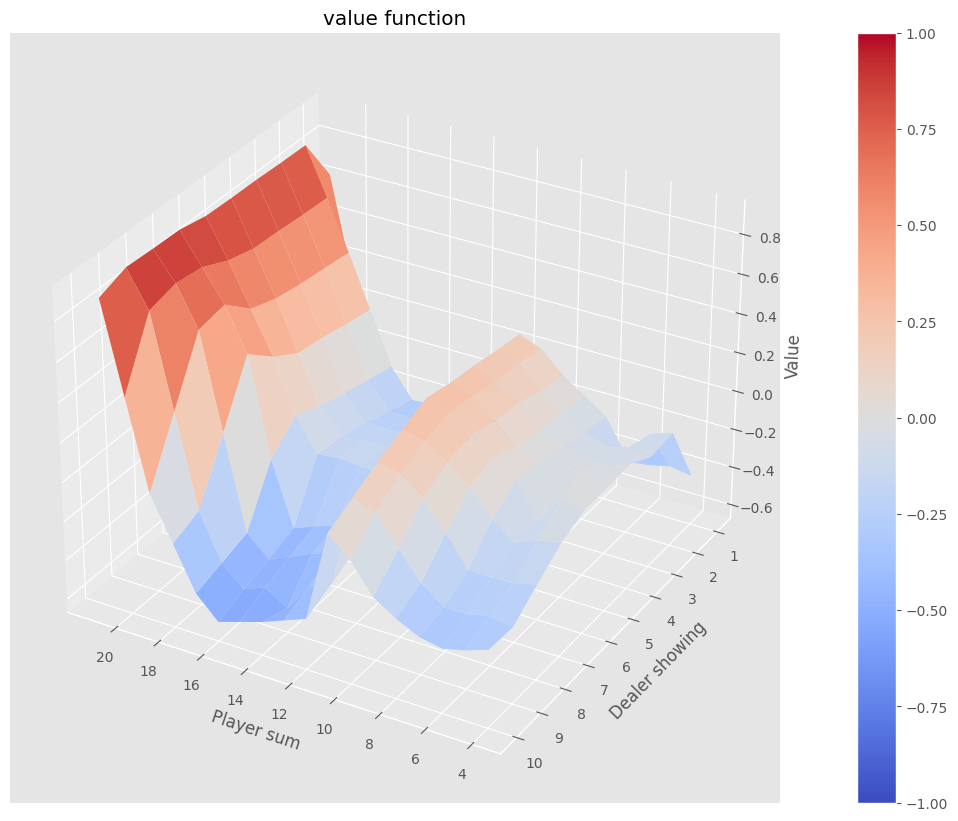

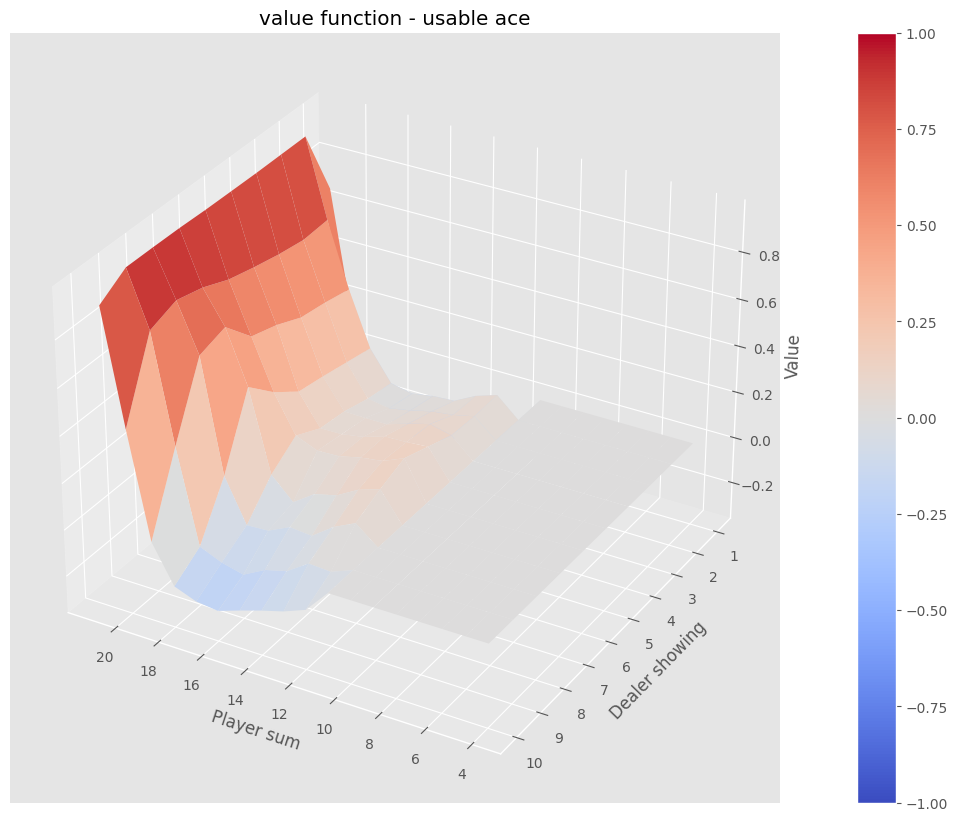

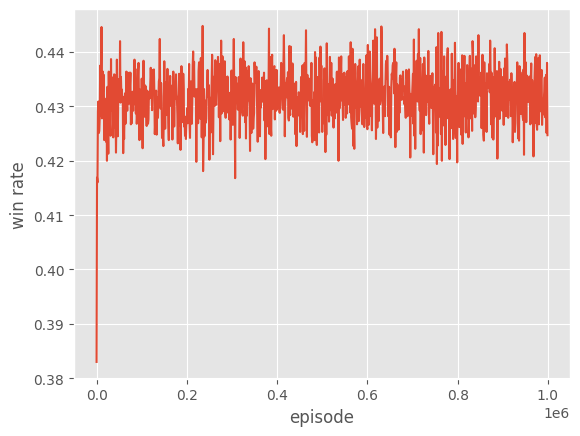

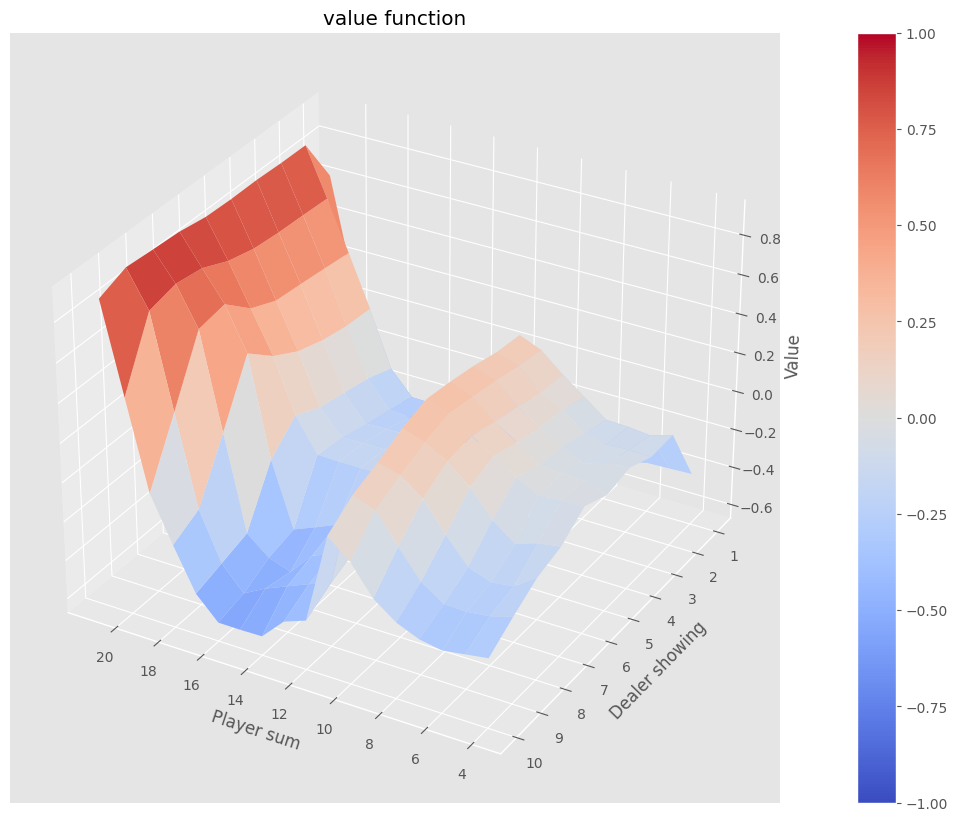

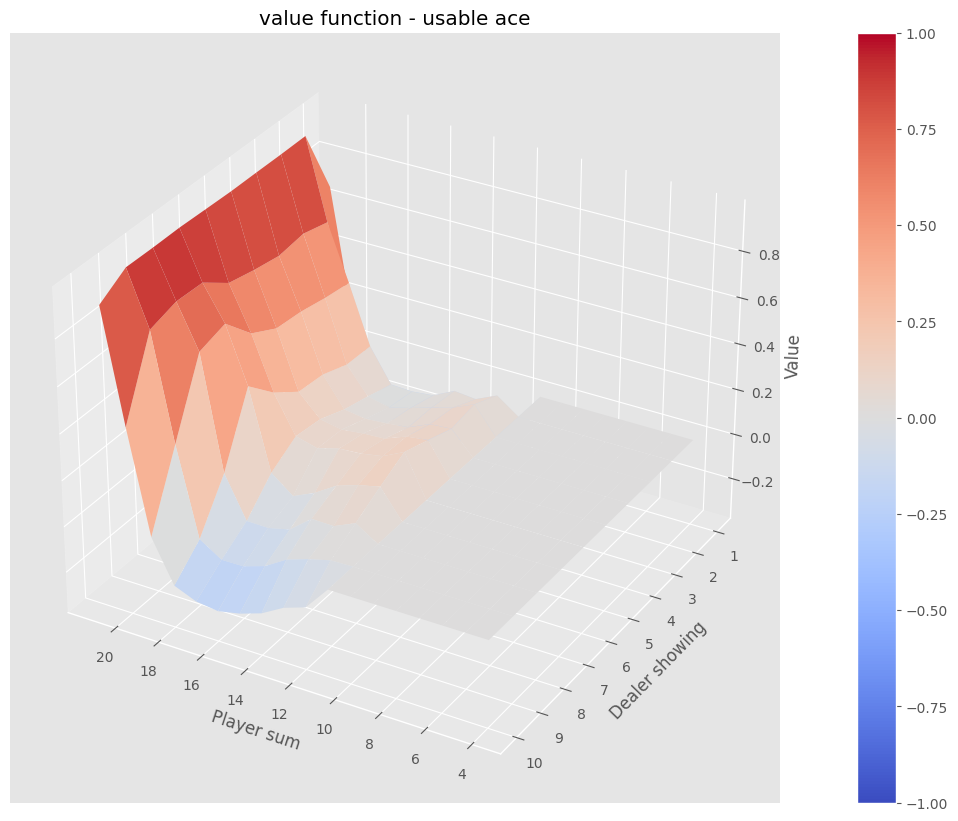

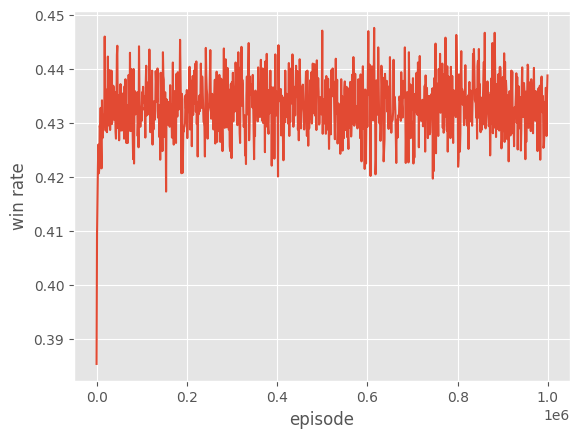

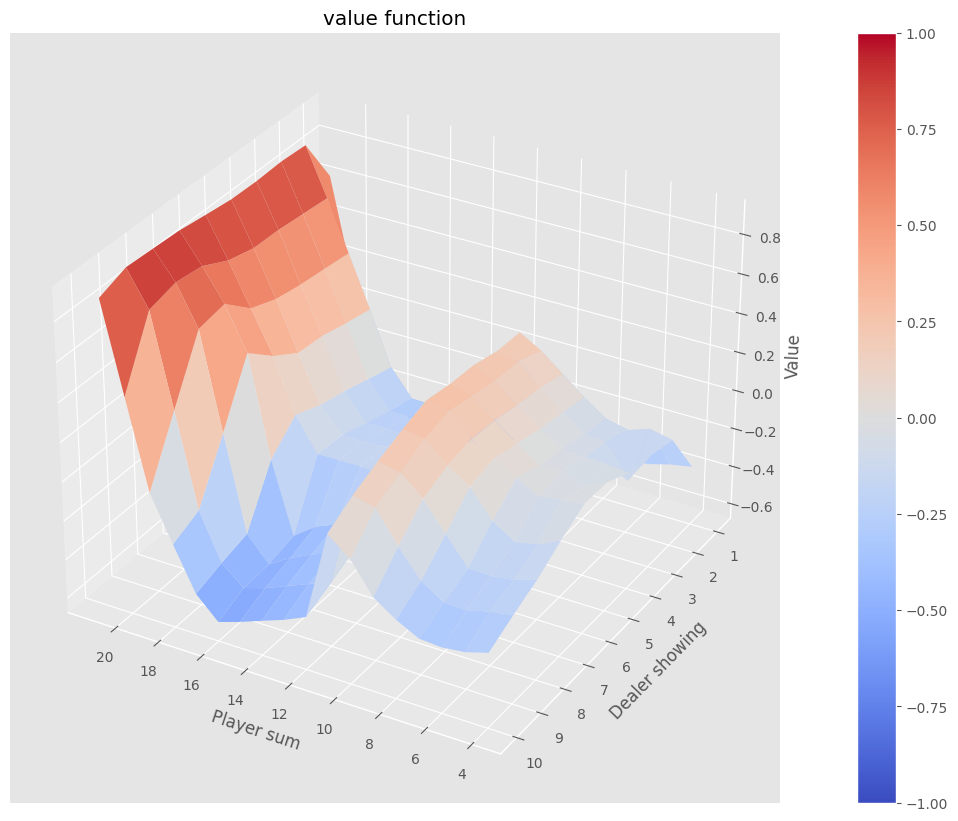

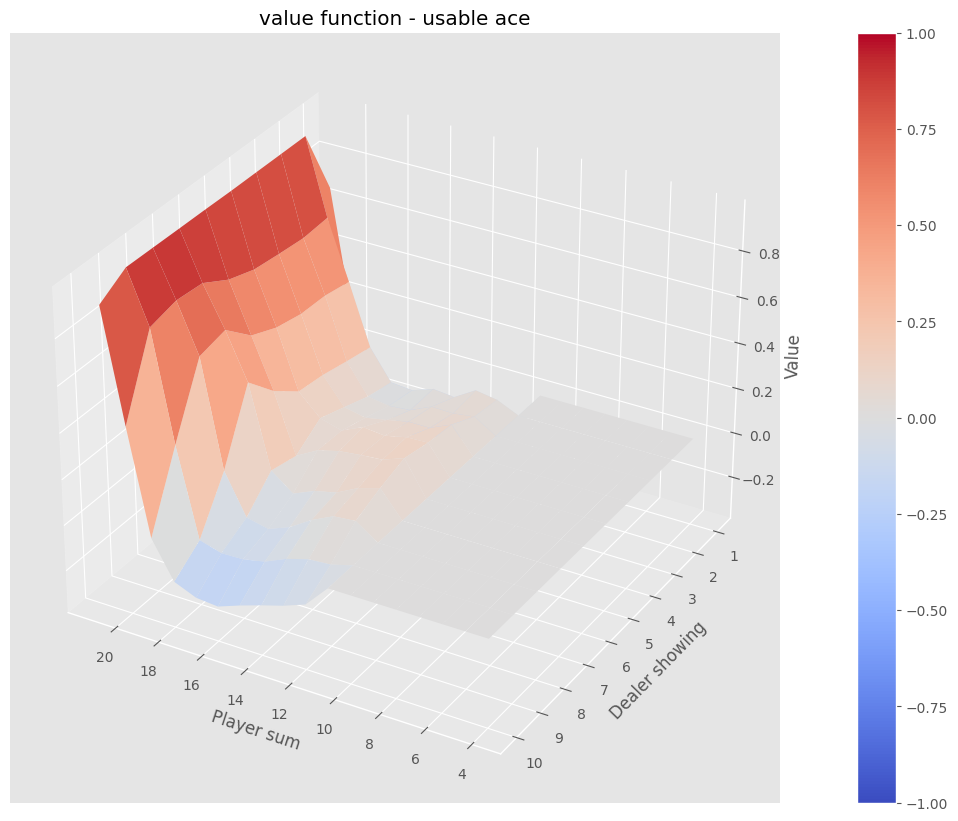

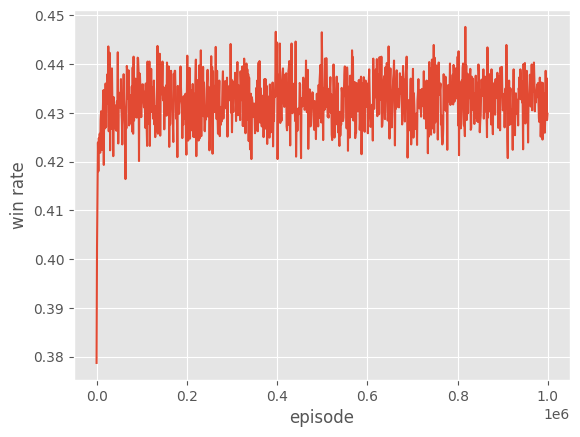

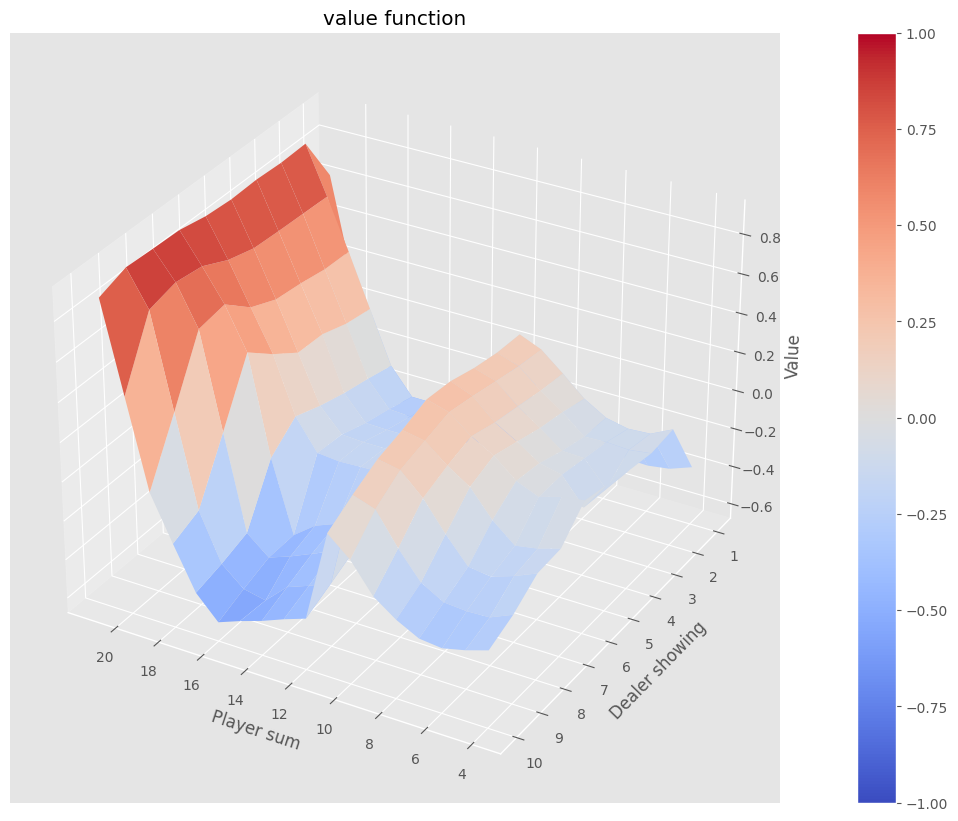

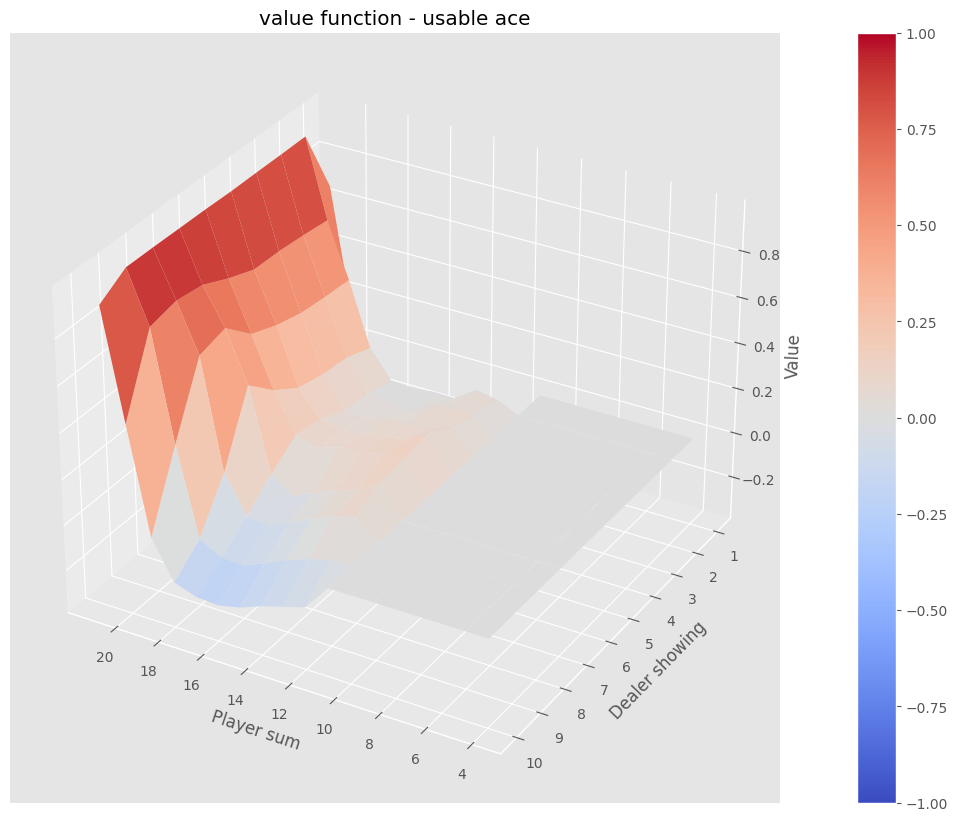

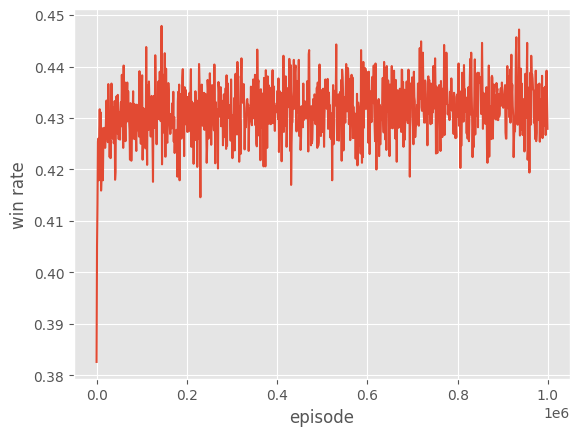

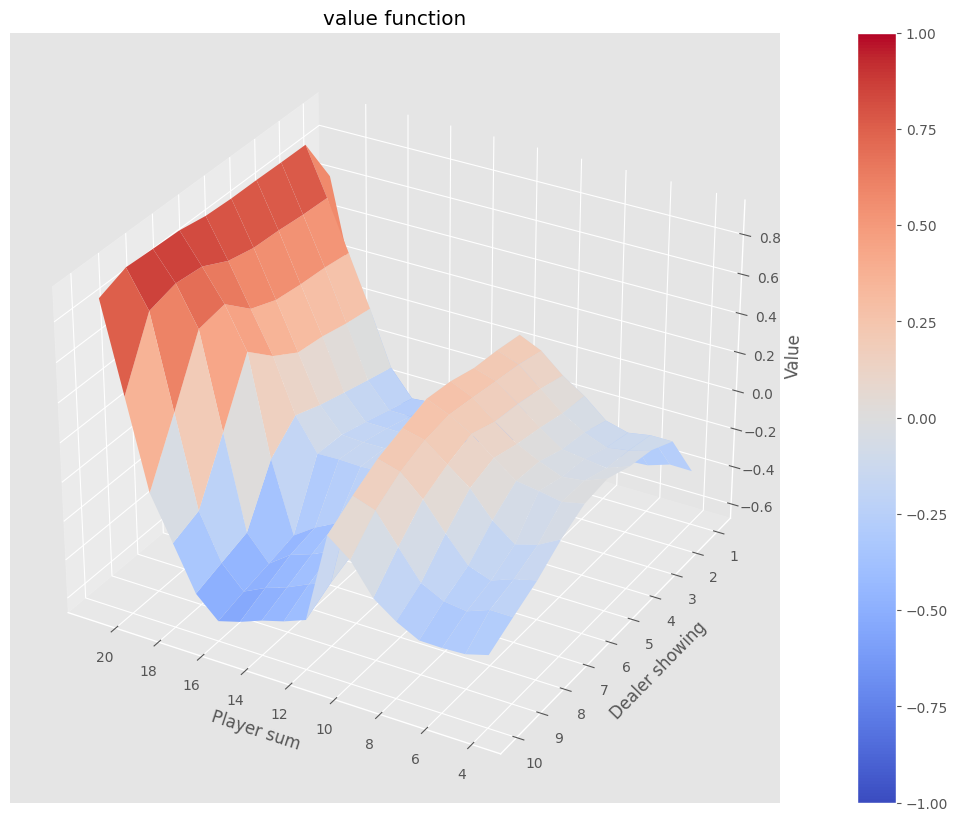

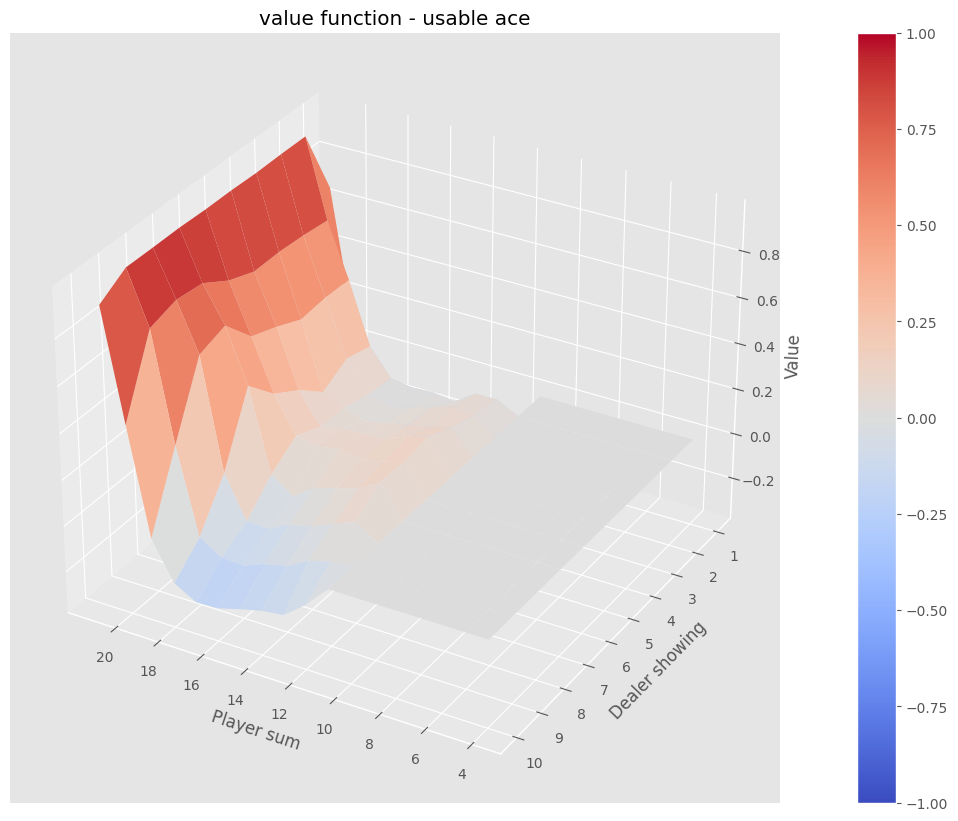

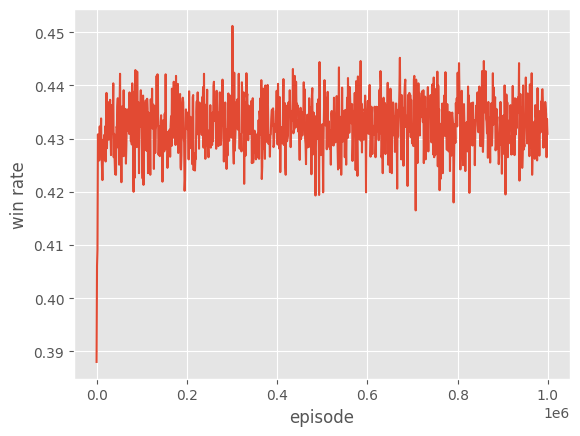

In [ ]:
Q_mc, evaluations = monte_carlo_ensemble(gamma=gamma, episodes=episodes, evaluate=True)
for i in range(len(Q_mc)):
  plot_value_function(Q_mc[i])
  plot_win_rate(evaluations[i])